# 1. 이진분류_콘크리트크랙

## (1) import

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [26]:
from glob import glob

import zipfile
import os
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# 전처리, 학습
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

## (2) 데이터 확인

In [3]:
folder_path = '/content/drive/MyDrive/고수의클래스_0906/3교시_이미지처리/이진분류_콘크리트크랙'

##### 필요할 진 모르겠는 코드..

In [4]:
# 이미지 압축 파일 해제
# with zipfile.ZipFile(folder_path + '...images.zip', 'r') as zip_ref:
#     zip_ref.extractall(folder_path)

with zipfile.ZipFile(folder_path + '/concrete_image_cjk.zip', 'r') as zip_ref:
  zip_ref.extractall('src_cjk')

In [5]:
# train/test 이미지가 들어있는 폴더의 경로
# train = '...images/train'
# test = '...images/test'

train = '/content/src_cjk/src_cjk'
test = '/content/src_cjk/test_cjk'
print(len(os.listdir(train)))
print(len(os.listdir(test)))

39800
200


In [6]:
# 이미지가 분류되어 있지 않고, 파일명에 기입되어 있는 경우 사용하는 코드
if not os.path.exists('IMAGE'):
    os.mkdir('IMAGE')
if not os.path.exists('IMAGE/negative'):
    os.mkdir('IMAGE/negative')
if not os.path.exists('IMAGE/positive'):
    os.mkdir('IMAGE/positive')

count = 0
# 파일명 예시: 0_0_0_20161219140623097_Negative.jpg or 0_0_0_20161219140523931_Positive.jpg
for filename in os.listdir(train):
    if filename.endswith('.jpg'):
        label = filename.split("_")[-1].split(".")[0]

        if label == "negative":
            # 현재 폴더에서 Negative 폴더로 파일 복사
            shutil.copy(os.path.join(train, filename), os.path.join('IMAGE/negative', filename))
        elif label == "positive":
            # 현재 폴더에서 Positive 폴더로 파일 복사
            shutil.copy(os.path.join(train, filename), os.path.join('IMAGE/positive', filename))

In [7]:
# 이미지 개수 확인 !! 폴더 경로 수정 필요
!ls -l ./IMAGE/negative/ | grep jpg | wc -l

19900


In [8]:
# 이미지 개수 확인 !! 폴더 경로 수정 필요
!ls -l ./IMAGE/positive/ | grep jpg | wc -l

19900


In [9]:
# 이미지 파일 하나 확인
path = 'IMAGE/positive/' + os.listdir('IMAGE/positive')[1]
print('path:', path)

path: IMAGE/positive/img_13113_1_positive.jpg


In [10]:
gfile = tf.io.read_file(path)
image = tf.io.decode_image(gfile, dtype=tf.float32)
print('image.shape:', image.shape)

image.shape: (227, 227, 3)


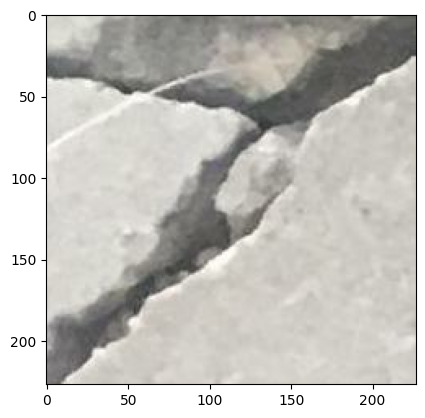

In [11]:
plt.imshow(image)
plt.show()

## (3) 데이터 전처리

In [ ]:
# ImageDataGenerator: 이미지 데이터에 대해 scaling, augmentation, validattion_split 전처리 기능 수행
# flow_from_directory: 실제 이미지 데이터를 읽고 배치, 셔플하고 labeling 수행

In [ ]:
# 1개 IMAGE 폴더로 Train, Test dataset으로 나눠야 하므로, validation_split 사용
# Data augmentation(이미지 변형을 통한 데이터 증강)을 사용하지 않음
# validation 데이터 사이즈 입력 : validation_split=0.2 --> 20%
# (주의점) MobileNetV2에 인풋으로 사용하기 전에 전 처리하는 코드가 preprocess_input으로 함수화 되어 있습니다. 따라서 그대로 사용하시면 됩니다.
# 그래서 rescale 수행하지 않음

In [12]:
image_datagen = ImageDataGenerator(
    # rescale=1./255,
    validation_split=0.2, # MobileNetV2의 경우, 아래 preprocess_input을 호출해서 리스케일 함
    preprocessing_function=preprocess_input
    # rotation_range=30,
    # width_shift_range=0.1,
    # height_shift_range=0.1,
    # shear_range=0.1,
    # zoom_range=0.1,
    # horizontal_flip=True,
    # fill_mode='nearest'
)

## (4) 학습

In [13]:
# 이미지 폴더 내 데이터를 읽고, 배치, 셔플하고 라벨링 수행
num_epochs = 10
batch_size = 32

learning_rate = 0.001
dropout_rate = 0.5

input_shape = (224, 224, 3) # MovileNetV2의 기본 입력값을 위해 사이즈 변경
num_classes = 2

In [14]:
# 이미지 폴더 내의 데이터  읽고 배치 , 셔플하고 labeling 수행
# 실제로 1개 IMAGE 폴더에서 Train 32000건, Test 8000건 dataset 만듬
# 2개 Class에 대한 라벨링(라벨인코딩,원핫인코딩) 수행
# MobileNetV2은 [96, 128, 160, 192, 224] 사이즈만 지원하므로 flow_from_directory 함수에서 사이즈 변경함
# subset = 'training' --> training_generator 생성
# subset = 'validation' --> test_generator 생성

# IMAGE 폴더 밑에 .ipynb_checkpoints 폴더 있을경우 폴더 삭제
#!rm -rf ./IMAGE/.ipynb_checkpoints

training_generator = image_datagen.flow_from_directory(
    './IMAGE', # 데이터 저장 경로? flow_from_directory를 써서 카테고리 별로 경로를 구분하지 않아도 됨
    batch_size=batch_size,
    target_size=(224, 224),
    class_mode='categorical', # 이진분류이긴 한데... 이상하다고 다중분류 적긴 하심 ( 원핫코드? 가 나와서.. 카테고리가 맞다고 하심 )
    shuffle=True,
    subset='training'
)

test_generator = image_datagen.flow_from_directory(
    './IMAGE',
    batch_size=batch_size,
    target_size=(224, 224),
    class_mode='categorical',
    shuffle=True,
    subset='validation'
)

Found 31840 images belonging to 2 classes.
Found 7960 images belonging to 2 classes.


In [15]:
# 사전 훈련된 모델 MobileNet V2에서 기본 모델을 생성합니다.
# 아래와 같은 형식을 Transfer Learning 사용하며 됩니다. 우리는 그냥 불러다 사용할줄 알면 됩니다.

base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [16]:
# MobieNet V2 베이스 모델 고정하기
base_model.trainble = False

In [17]:
# 모델 구축
x = base_model.output

x = tf.keras.layers.GlobalAveragePooling2D()(x) # GlobalAveragePooling2D: 3차원 텐서를 1차원으로 변환
output = tf.keras.layers.Dense(num_classes, activation='softmax')(x) # num_classes: 2

model = tf.keras.Model(inputs=base_model.input, outputs=output)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,260,546 (8.62 MB)

 Trainable params: 2,226,434 (8.49 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [18]:
# 모델 컴파일
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),  # Optimization
              loss='categorical_crossentropy',  # Loss Function
              metrics=['accuracy'])             # Metrics / Accuracy

In [19]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)

checkpoint_path = 'my_checkpoint.ckpt.weights.h5'
checkpoint = ModelCheckpoint(
    filepath = checkpoint_path,
    save_weights_only=True,
    save_best_only=True,
    monitor='val_loss',
    verbose=1
)

lrReducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.0001)

In [20]:
# 학습
history = model.fit(
    training_generator,
    validation_data=test_generator,
    epochs=num_epochs, # num_epochs: 10
    batch_size=batch_size,
    callbacks=[es, checkpoint, lrReducer]
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


995/995 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.9833 - loss: 0.0531
Epoch 1: val_loss improved from inf to 0.27382, saving model to my_checkpoint.ckpt.weights.h5
995/995 ━━━━━━━━━━━━━━━━━━━━ 205s 153ms/step - accuracy: 0.9833 - loss: 0.0531 - val_accuracy: 0.9590 - val_loss: 0.2738 - learning_rate: 0.0010
Epoch 2/10
995/995 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.9969 - loss: 0.0106
Epoch 2: val_loss improved from 0.27382 to 0.13933, saving model to my_checkpoint.ckpt.weights.h5
995/995 ━━━━━━━━━━━━━━━━━━━━ 131s 131ms/step - accuracy: 0.9969 - loss: 0.0106 - val_accuracy: 0.9695 - val_loss: 0.1393 - learning_rate: 0.0010
Epoch 3/10
995/995 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.9972 - loss: 0.0094
Epoch 3: val_loss improved from 0.13933 to 0.02598, saving model to my_checkpoint.ckpt.weights.h5
995/995 ━━━━━━━━━━━━━━━━━━━━ 123s 123ms/step - accuracy: 0.9972 - loss: 0.0094 - val_accuracy: 0.9966 - val_loss: 0.0260 - learning_rate: 0.0010
Epoch 4/10
995/995 ━━━

## (5) 결과 제출

In [23]:
model.save("01073002902_3.h5")

In [25]:
# test 폴더의 파일명으로 csv의 target column 만들기
targets = []

for item in os.listdir(test): # test 데이터 경로
    targets.append(item.split(".")[0]) # 확장자를 제외한 파일명만 추출
print(targets)

['img_00123_negative', 'img_00170_negative', 'img_00124_negative', 'img_00153_negative', 'img_00105_negative', 'img_00165_positive', 'img_00192_negative', 'img_00133_negative', 'img_00150_positive', 'img_00180_negative', 'img_00111_positive', 'img_00110_negative', 'img_00121_negative', 'img_00186_positive', 'img_00190_negative', 'img_00175_negative', 'img_00139_positive', 'img_00122_negative', 'img_00184_positive', 'img_00162_negative', 'img_00169_negative', 'img_00152_positive', 'img_00144_negative', 'img_00159_negative', 'img_00119_negative', 'img_00147_positive', 'img_00145_positive', 'img_00148_negative', 'img_00112_positive', 'img_00164_negative', 'img_00195_positive', 'img_00168_negative', 'img_00116_positive', 'img_00150_negative', 'img_00138_positive', 'img_00143_negative', 'img_00197_positive', 'img_00183_negative', 'img_00190_positive', 'img_00177_negative', 'img_00132_negative', 'img_00146_negative', 'img_00142_negative', 'img_00113_positive', 'img_00169_positive', 'img_0017

In [28]:
result = []
answer_class = {0: 'negative', 1: 'positive'}
right = 0
total = 0

for target in targets:
    total += 1
    test_image_path = os.path.join("src_cjk/test_cjk/", target + '.jpg') # test 이미지 경로로 변경
    img = load_img(test_image_path, target_size=(224, 224)) # 파일 변환 사이즈만 알려주면 됨
    img_array = img_to_array(img) # 읽은 이미지를 Numpy 배열로변환 (224, 224, 3) 크기.
    img_array = np.expand_dims(img_array, axis=0) # 배열 차원 확장 (1, 224, 224, 3)

    # 이미지 데이터 전처리
    img_array = preprocess_input(img_array)

    # 예측
    predictions = model.predict(img_array)
    print(predictions)

    # 예측 결과
    predicted_class = np.argmax(predictions, axis=1)
    confidence = np.max(predictions, axis=1)

    # 클래스 인덱스를 클래스명으로 변환
    pred = answer_class[predicted_class[0]]
    result.append(pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
[[9.9999726e-01 2.7334320e-06]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[[9.9999952e-01 4.6357232e-07]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[[1.0000000e+00 1.2632986e-08]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[[1.000000e+00 1.233759e-08]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[[9.9999738e-01 2.5796378e-06]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[[7.5737727e-10 1.0000000e+00]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[[9.9999881e-01 1.2100965e-06]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[[9.9999988e-01 1.1089406e-07]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[[1.3718493e-06 9.9999857e-01]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
[[1.000000e+00 1.799531e-08]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
[[1.9164377e-09 1.0000000e+00]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
[[9.9999809e-01 1.9173365e-06]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[[9.9999940e-01 5.5464034e-07]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[[2.1624212e-08 1.0000000e+00]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

In [30]:
final = pd.DataFrame({"target": targets, "result": result})
final.head()

,target,result
0,img_00123_negative,negative
1,img_00170_negative,negative
2,img_00124_negative,negative
3,img_00153_negative,negative
4,img_00105_negative,negative


In [31]:
final.to_csv('01073002902_3.csv', index=False)

# 2. 다중분류_꽃사진분류

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## (1) import

In [19]:
from glob import glob

import zipfile
import os
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# 전처리, 학습
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input, decode_predictions
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

## (2) 데이터 확인

In [20]:
folder_path = '/content/drive/MyDrive/고수의클래스_0906/3교시_이미지처리/다중분류_꽃종류분류'

In [21]:
# with zipfile.ZipFile(folder_path + '...images.zip', 'r') as zip_ref:
#     zip_ref.extractall(folder_path)

with zipfile.ZipFile(folder_path + '/flower_photos_cjk5.zip', 'r') as zip_ref:
    zip_ref.extractall('src_cjk')

In [22]:
# train/test 이미지가 들어있는 폴더의 경로
# train = '...images/train'
# test = '...images/test'

In [23]:
# 이미지가 분류되어 있지 않고, 파일명에 기입되어 있는 경우 사용하는 코드
if not os.path.exists('IMAGE'):
    os.mkdir('IMAGE')
if not os.path.exists('IMAGE/daisy'):
    os.mkdir('IMAGE/daisy')
if not os.path.exists('IMAGE/dandelion'):
    os.mkdir('IMAGE/dandelion')
if not os.path.exists('IMAGE/tulips'):
    os.mkdir('IMAGE/tulips')
if not os.path.exists('IMAGE/roses'):
    os.mkdir('IMAGE/roses')
if not os.path.exists('IMAGE/sunflowers'):
    os.mkdir('IMAGE/sunflowers')

for filename in os.listdir("src_cjk/cjk_src"):
    if filename.endswith('.jpg'):
        label=filename.split("_")[-1].split(".")[0]
        if(label=="daisy"):
          shutil.copy(os.path.join("src_cjk/cjk_src", filename), os.path.join("IMAGE/daisy", filename))
        elif(label=="dandelion"):
          shutil.copy(os.path.join("src_cjk/cjk_src", filename), os.path.join("IMAGE/dandelion", filename))
        elif(label=="tulips"):
          shutil.copy(os.path.join("src_cjk/cjk_src", filename), os.path.join("IMAGE/tulips", filename))
        elif(label=="roses"):
          shutil.copy(os.path.join("src_cjk/cjk_src", filename), os.path.join("IMAGE/roses", filename))
        elif(label=="sunflowers"):
          shutil.copy(os.path.join("src_cjk/cjk_src", filename), os.path.join("IMAGE/sunflowers", filename))

In [24]:
# daisy 폴더 안의 이미지 개수 !! 폴더 경로 수정 필요
!ls -l IMAGE/daisy | grep jpg | wc -l

613


In [25]:
# 이미지 패스 지정
img_path = 'IMAGE'

## (3) 데이터 전처리

In [26]:
image_datagen = ImageDataGenerator(
    # rescale=1./255,
    validation_split=0.2, # MobileNetV2의 경우, 아래 preprocess_input을 호출해서 리스케일 함
    preprocessing_function=preprocess_input
    # rotation_range=30,
    # width_shift_range=0.1,
    # height_shift_range=0.1,
    # shear_range=0.1,
    # zoom_range=0.1,
    # horizontal_flip=True,
    # fill_mode='nearest'
)

## (4) 학습

In [27]:
num_epochs = 4
batch_size = 32

learning_rate = 0.001
dropout_rate = 0.5

input_shape = (224, 224, 3)  # 사이즈 확인
num_classes = 5    #  다섯 가지의 꽃 종류

In [28]:
# IMAGE 폴더 밑에 .ipynb_checkpoints 폴더 있을경우 폴더 삭제
#!rm -rf ./IMAGE/.ipynb_checkpoints

training_generator = image_datagen.flow_from_directory(
    img_path, # 데이터 저장 경로? flow_from_directory를 써서 카테고리 별로 경로를 구분하지 않아도 됨
    batch_size=batch_size,
    target_size=(224, 224),
    class_mode='categorical', # 이진분류이긴 한데... 이상하다고 다중분류 적긴 하심 ( 원핫코드? 가 나와서.. 카테고리가 맞다고 하심 )
    shuffle=True,
    subset='training'
)

test_generator = image_datagen.flow_from_directory(
    img_path,
    batch_size=batch_size,
    target_size=(224, 224),
    class_mode='categorical',
    shuffle=True,
    subset='validation'
)

Found 2859 images belonging to 5 classes.
Found 711 images belonging to 5 classes.


In [29]:
# class 이름 및 번호 매핑 확인
print(training_generator.class_indices)

{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}


One Hot Encoding :  [0. 0. 1. 0. 0.]
(224, 224, 3)


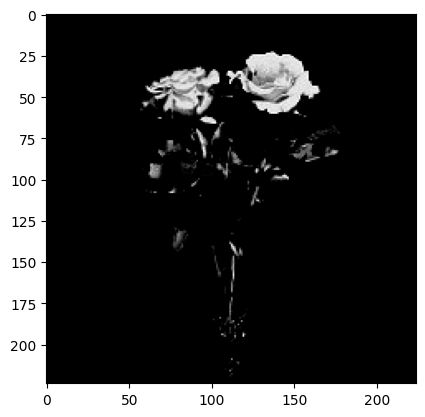

In [30]:
# 이미지 확인
batch_samples = next(iter(training_generator))

print('One Hot Encoding : ',batch_samples[1][0]) #label 배치의 첫번째 값
print(batch_samples[0][0].shape)  #이미지 배치의 첫번째 이미지
plt.imshow(batch_samples[0][0])
plt.show()

In [31]:
# 이미지 크기 확인
print(batch_samples[0].shape)
print(batch_samples[1].shape)

(32, 224, 224, 3)
(32, 5)


In [32]:
# 사전 훈련된 모델 MobileNet V2에서 기본 모델을 생성합니다.
# 아래와 같은 형식을 Transfer Learning 사용하며 됩니다. 우리는 그냥 불러다 사용할줄 알면 됩니다.

base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

In [33]:
len(base_model.layers)

154

In [35]:
# MobieNet V2 베이스 모델 고정하기
base_model.trainble = False

In [36]:
# 모델 구축
x = base_model.output

x = tf.keras.layers.GlobalAveragePooling2D()(x) # GlobalAveragePooling2D: 3차원 텐서를 1차원으로 변환
output = tf.keras.layers.Dense(5, activation='softmax')(x) # num_classes:5

model = tf.keras.Model(inputs=base_model.input, outputs=output)
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,264,389 (8.64 MB)

 Trainable params: 2,230,277 (8.51 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [37]:
# 모델 컴파일
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),  # Optimization
              loss='categorical_crossentropy',  # Loss Function
              metrics=['accuracy'])             # Metrics / Accuracy

In [38]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)

checkpoint_path = 'my_checkpoint.ckpt.weights.h5'
checkpoint = ModelCheckpoint(
    filepath = checkpoint_path,
    save_weights_only=True,
    save_best_only=True,
    monitor='val_loss',
    verbose=1
)

lrReducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.0001)

In [ ]:
# 학습
history = model.fit(
    training_generator,
    validation_data=test_generator,
    epochs=num_epochs, # num_epochs: 4
    batch_size=batch_size,
    callbacks=[es, checkpoint, lrReducer]
)

Epoch 1/4


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/90 ━━━━━━━━━━━━━━━━━━━━ 9:58 8s/step - accuracy: 0.5865 - loss: 1.0356 

## (5) 그래프 확인

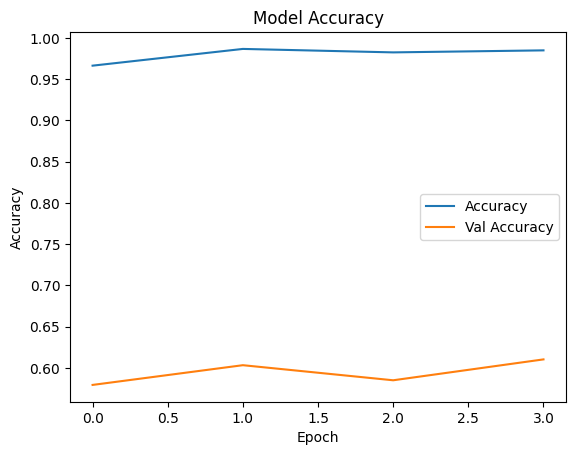

In [39]:
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()

## (6) 결과 제출

In [ ]:
model.save("01073002902_3.h5")

In [ ]:
# test 폴더의 파일명으로 csv의 target column 만들기
target = []
result = []

for item in os.listdir(test): # test 데이터 경로
    target.append(item.split(".")[0]) # 확장자를 제외한 파일명만 추출

final = pd.DataFrame({"target": target, "result": result})

In [ ]:
result = []
answer_class = {0: 'daisy', 1: 'dandelion', 2: 'roses', 3: 'sunflowers', 4: 'tulips'}

In [ ]:
result = []
right = 0
total = 0

for image, label in zip(final['target'], final['result']):
    total += 1
    test_image_path = os.path.join(test, image + '.jpg')
    img = load_img(test_image_path, target_size=(224, 224)) # 파일 변환 사이즈만 알려주면 됨
    img_array = img_to_array(img) # 읽은 이미지를 Numpy 배열로변환 (224, 224, 3) 크기.
    img_array = np.expand_dims(img_array, axis=0) # 배열 차원 확장 (1, 224, 224, 3)

    # 이미지 데이터 전처리
    img_array = preprocess_input(img_array)

    # 예측
    predictions = model.predict(img_array)
    print(predictions)

    # 예측 결과
    predicted_class = np.argmax(predictions, axis=1)
    confidence = np.max(predictions, axis=1)

    # 클래스 인덱스를 클래스명으로 변환
    pred = answer_class[predicted_class[0]]
    result.append(pred)

In [ ]:
final['result'] = result
final.head()

In [ ]:
final.to_csv('01073002902_3.csv', index=False)